In [1]:
import matplotlib.pyplot as plt
import numpy as np
import openmm
from openmm import unit
from colloids import ColloidPotentialsAlgebraic, ColloidPotentialsParameters

%matplotlib inline

In [2]:
radius_positive = 325.0 * unit.nanometer
radius_negative = 65.0 * unit.nanometer
surface_potential_positive = 50.0 * (unit.milli * unit.volt)
surface_potential_negative = -50.0 * (unit.milli * unit.volt)
colloid_potential_parameters = ColloidPotentialsParameters(
    brush_density=0.09 / (unit.nanometer ** 2), brush_length=10.0 * unit.nanometer,
    debye_length=6.0 * unit.nanometer, temperature=298.0 * unit.kelvin,
    dielectric_constant=80.0)

In [3]:
def get_potentials(h_values, radius_one, radius_two, surface_potential_one, surface_potential_two, 
                   parameters, platform_name="Reference"):
    # Set up system.
    system = openmm.System()
    # Make system very large so that we do not care about periodic boundaries.
    side_length = 200.0 * (max(h_values) + radius_one.value_in_unit(unit.nanometer) + radius_two.value_in_unit(unit.nanometer)) 
    system.setDefaultPeriodicBoxVectors([side_length, 0.0, 0.0],
                                        [0.0, side_length, 0.0],
                                        [0.0, 0.0, side_length])
    colloid_potentials = ColloidPotentialsAlgebraic(
        colloid_potentials_parameters=parameters, use_log=False)
    
    # Add two particles to the system and forces (mass is unimportant for the potential energies).
    system.addParticle(mass=1.0)
    colloid_potentials.add_particle(radius=radius_one, surface_potential=surface_potential_one)
    system.addParticle(mass=1.0)
    colloid_potentials.add_particle(radius=radius_two, surface_potential=surface_potential_two)

    # Add forces.
    for potential in colloid_potentials.yield_potentials():
        system.addForce(potential)
        
    for force in system.getForces():
        print(f"Energy function: {force.getEnergyFunction()}")
        print(f"Nonbonded method: {force.getNonbondedMethod()}, Cutoff distance: {force.getCutoffDistance()}")
        assert force.usesPeriodicBoundaryConditions()
        assert not force.getUseLongRangeCorrection()
    
    # Set up platform and context. The platform_name is typically Reference or CUDA.
    platform = openmm.Platform.getPlatformByName(platform_name)
    dummy_integrator = openmm.LangevinIntegrator(
        parameters.temperature.value_in_unit(unit.kelvin), 0.0, 0.0)
    context = openmm.Context(system, dummy_integrator, platform)
    print(f"Using {context.getPlatform().getName()} platform.")
    if context.getPlatform().getName() == "CUDA":
        for cuda_property in ("Precision", "TempDirectory", "UseCpuPme", "DeviceIndex", "UseBlockingSync", "DeterministicForces"):
            print(f"{cuda_property}: {context.getPlatform().getPropertyValue(context, cuda_property)}")
    
    
    potential_energies = np.zeros(len(h_values))
    for h_index, h_value in enumerate(h_values):
        context.setPositions([[(radius_one + radius_two).value_in_unit(unit.nanometer) + h_value, 0.0, 0.0], [0.0, 0.0, 0.0]])
        state = context.getState(getEnergy=True)
        potential_energies[h_index] = (
            state.getPotentialEnergy()
            / (unit.BOLTZMANN_CONSTANT_kB * parameters.temperature * unit.AVOGADRO_CONSTANT_NA)
        )
    
    return potential_energies

Energy function: step(two_l - h) * steric_prefactor * rs / 2.0 * brush_length * brush_length * (28.0 * ((two_l / h)^0.25 - 1.0) + 20.0 / 11.0 * (1.0 - (h / two_l)^2.75)+ 12.0 * (h / two_l - 1.0)); h = r - rs;rs = radius1 + radius2;two_l = 2.0 * brush_length
Nonbonded method: 2, Cutoff distance: 1020.0 nm
Energy function: electrostatic_prefactor * radius * psi1 * psi2 * exp(-h / debye_length); radius = 2.0 / (1.0 / radius1 + 1.0 / radius2);h = r - rs;rs = radius1 + radius2
Nonbonded method: 2, Cutoff distance: 1126.0 nm
Using Reference platform.


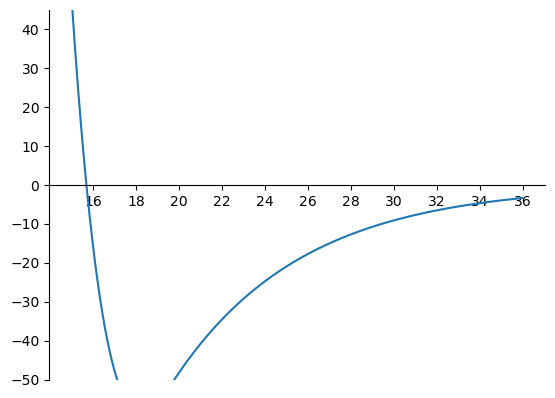

In [4]:
h_vals = np.linspace(15.0, 36.0, num=1000)
potential_vals = get_potentials(h_vals, 500 * unit.nanometer, 500 * unit.nanometer, 
                                surface_potential_positive, surface_potential_negative,
                                colloid_potential_parameters)

plt.figure()
plt.plot(h_vals, potential_vals)
plt.ylim(-50, 45)
plt.xticks([2 * i for i in range(8, 18 + 1)])
plt.yticks([10 * i for i in range(-5, 4 + 1)])
ax = plt.gca()
ax.spines["bottom"].set_position("zero")
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")
plt.show()
plt.close()